In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Wed Jan 24 19:16:54 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.9999

hp.M = hp.n_prior_embeddings

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform_notconst_1e-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 440475, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [ ]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

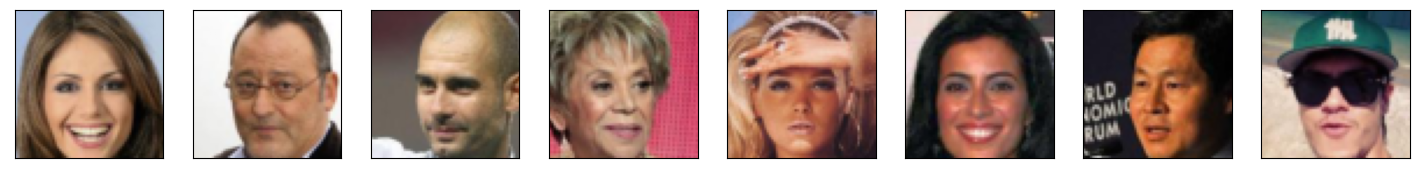

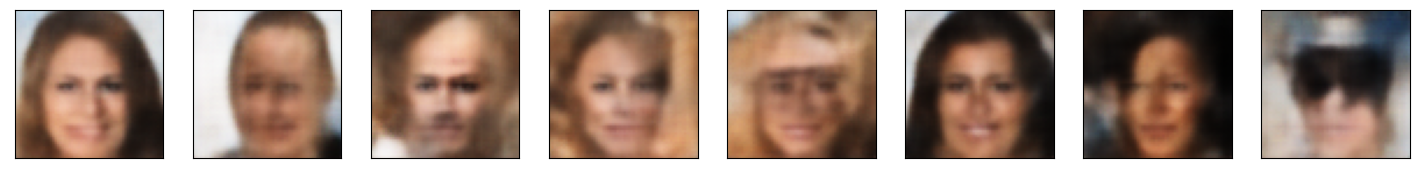

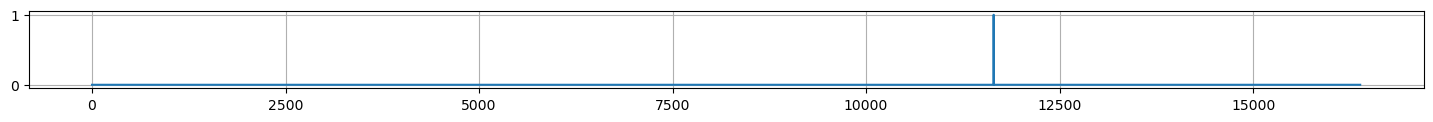

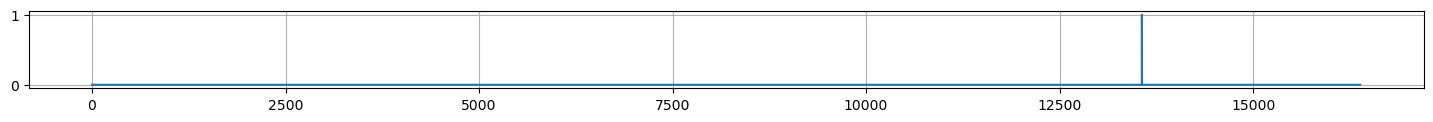

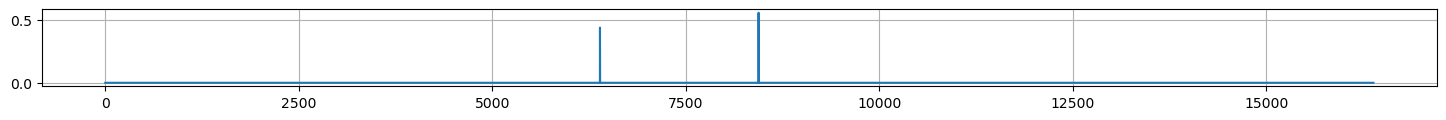

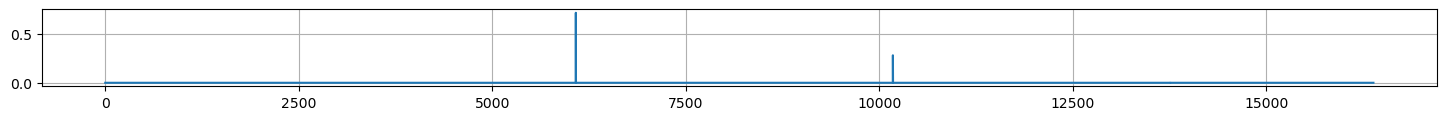

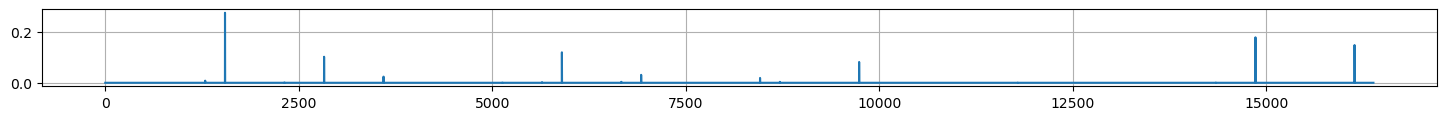

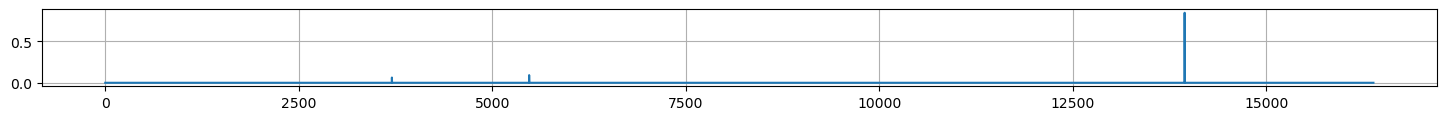

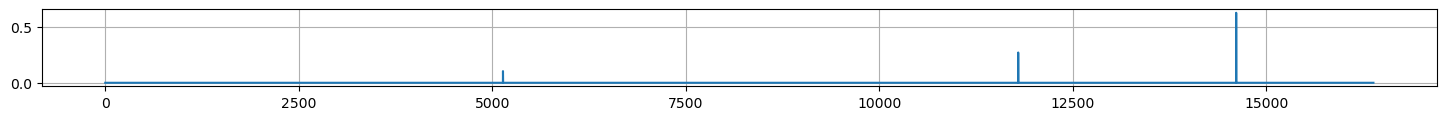

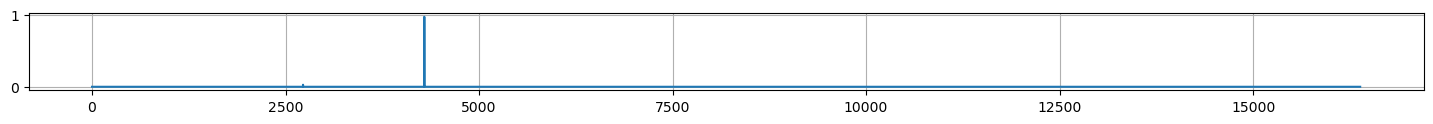

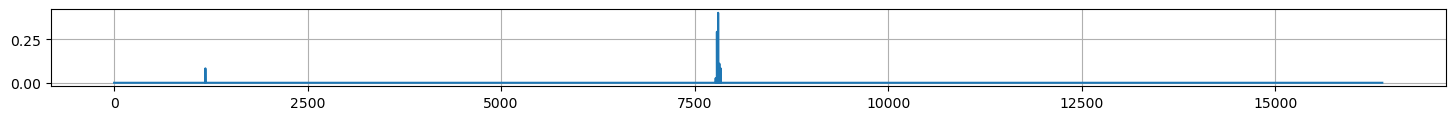

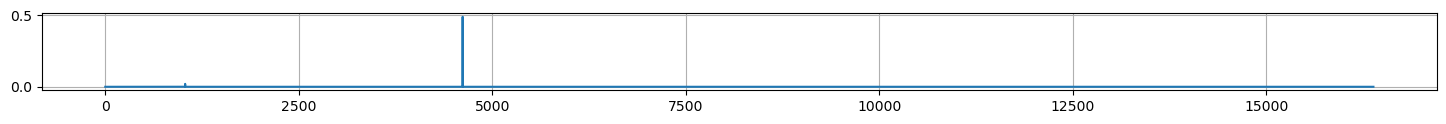

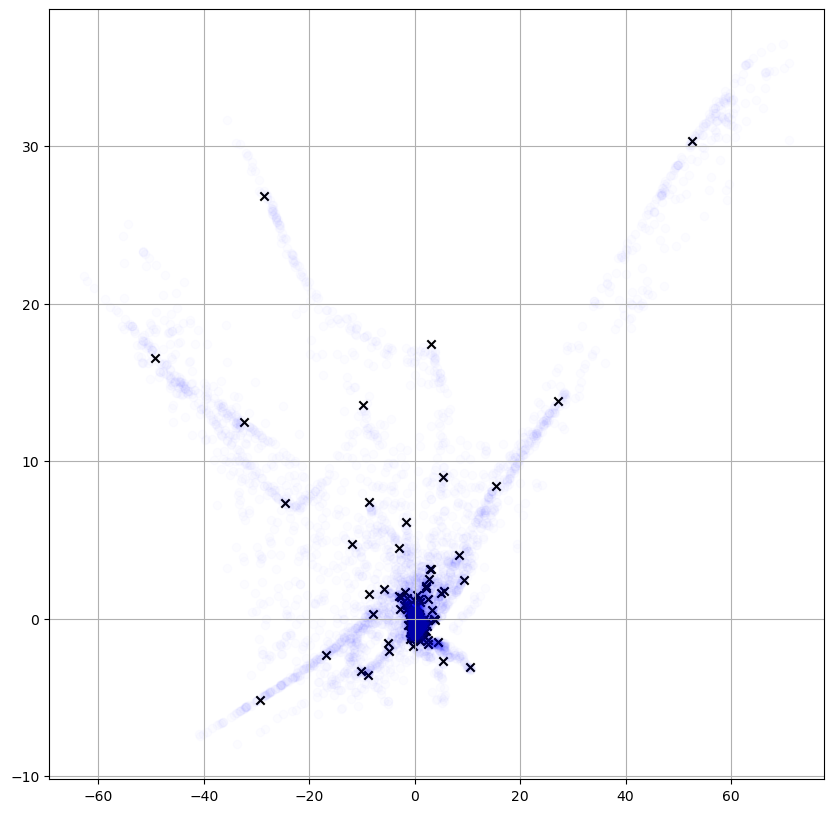

29001
lse_loss -194.77813720703125
commit_loss 0.12358003109693527
recon_loss 0.011377839371562004
29002
lse_loss -195.60704040527344
commit_loss 0.10090173035860062
recon_loss 0.012063886038959026
29003
lse_loss -196.83848571777344
commit_loss 0.09483565390110016
recon_loss 0.011553453281521797
29004
lse_loss -196.966064453125
commit_loss 0.09661448001861572
recon_loss 0.01206974871456623
29005
lse_loss -195.6497802734375
commit_loss 0.09820563346147537
recon_loss 0.011348026804625988
29006
lse_loss -197.59059143066406
commit_loss 0.10460501164197922
recon_loss 0.012059524655342102
29007
lse_loss -197.4761199951172
commit_loss 0.09816856682300568
recon_loss 0.01164534967392683
29008
lse_loss -197.1619110107422
commit_loss 0.08745971322059631
recon_loss 0.0113962572067976
29009
lse_loss -195.4464569091797
commit_loss 0.08607801049947739
recon_loss 0.01104060560464859
29010
lse_loss -197.61557006835938
commit_loss 0.08995531499385834
recon_loss 0.011552645824849606
29011
lse_loss -195.6

29086
lse_loss -195.33221435546875
commit_loss 0.11110596358776093
recon_loss 0.010479778051376343
29087
lse_loss -193.57266235351562
commit_loss 0.14170876145362854
recon_loss 0.011756728403270245
29088
lse_loss -196.04478454589844
commit_loss 0.09276916086673737
recon_loss 0.01196266245096922
29089
lse_loss -196.40733337402344
commit_loss 0.09438001364469528
recon_loss 0.01113959401845932
29090
lse_loss -194.88230895996094
commit_loss 0.13541960716247559
recon_loss 0.010224997065961361
29091
lse_loss -196.81175231933594
commit_loss 0.08925949037075043
recon_loss 0.011419279500842094
29092
lse_loss -195.59130859375
commit_loss 0.09698902815580368
recon_loss 0.011875334195792675
29093
lse_loss -196.3806915283203
commit_loss 0.09256129711866379
recon_loss 0.011032385751605034
29094
lse_loss -196.6812286376953
commit_loss 0.11387162655591965
recon_loss 0.011045873165130615
29095
lse_loss -196.1687469482422
commit_loss 0.09854382276535034
recon_loss 0.010269656777381897
29096
lse_loss -19

29171
lse_loss -196.20602416992188
commit_loss 0.10304996371269226
recon_loss 0.012084510177373886
29172
lse_loss -196.14622497558594
commit_loss 0.12958648800849915
recon_loss 0.012085683643817902
29173
lse_loss -195.7305450439453
commit_loss 0.09372150897979736
recon_loss 0.011453405022621155
29174
lse_loss -197.86795043945312
commit_loss 0.10449142009019852
recon_loss 0.010911708697676659
29175
lse_loss -197.70150756835938
commit_loss 0.1004735678434372
recon_loss 0.011587392538785934
29176
lse_loss -197.123779296875
commit_loss 0.10541849583387375
recon_loss 0.011566011235117912
29177
lse_loss -197.9956817626953
commit_loss 0.09279271960258484
recon_loss 0.011040184646844864
29178
lse_loss -197.0434112548828
commit_loss 0.10589945316314697
recon_loss 0.011847550980746746
29179
lse_loss -197.33509826660156
commit_loss 0.0913495197892189
recon_loss 0.011670604348182678
29180
lse_loss -198.01193237304688
commit_loss 0.1013135015964508
recon_loss 0.013732771389186382
29181
lse_loss -19

lse_loss -197.336669921875
commit_loss 0.11417832970619202
recon_loss 0.011770432814955711
29256
lse_loss -197.53988647460938
commit_loss 0.09432146698236465
recon_loss 0.010861980728805065
29257
lse_loss -198.36871337890625
commit_loss 0.08215503394603729
recon_loss 0.010862077586352825
29258
lse_loss -199.0809326171875
commit_loss 0.09653444588184357
recon_loss 0.010868638753890991
29259
lse_loss -197.9364471435547
commit_loss 0.09657974541187286
recon_loss 0.011587741784751415
29260
lse_loss -198.67611694335938
commit_loss 0.08795460313558578
recon_loss 0.010949778370559216
29261
lse_loss -199.17047119140625
commit_loss 0.0891052633523941
recon_loss 0.010660534724593163
29262
lse_loss -199.6862335205078
commit_loss 0.106033556163311
recon_loss 0.011612743139266968
29263
lse_loss -194.57989501953125
commit_loss 0.11236158013343811
recon_loss 0.011431371793150902
29264
lse_loss -196.99192810058594
commit_loss 0.0872054472565651
recon_loss 0.010521533899009228
29265
lse_loss -197.39888

lse_loss -198.0015106201172
commit_loss 0.10125166922807693
recon_loss 0.012379065155982971
29340
lse_loss -197.57191467285156
commit_loss 0.10314039140939713
recon_loss 0.010755231603980064
29341
lse_loss -197.10671997070312
commit_loss 0.08804678916931152
recon_loss 0.01105810608714819
29342
lse_loss -198.36085510253906
commit_loss 0.09646274894475937
recon_loss 0.011981355957686901
29343
lse_loss -197.760498046875
commit_loss 0.09316469728946686
recon_loss 0.01243520062416792
29344
lse_loss -197.91867065429688
commit_loss 0.09154366701841354
recon_loss 0.010447319597005844
29345
lse_loss -196.5299835205078
commit_loss 0.10880111157894135
recon_loss 0.012117295525968075
29346
lse_loss -198.48910522460938
commit_loss 0.10162033140659332
recon_loss 0.011277386918663979


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [25]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


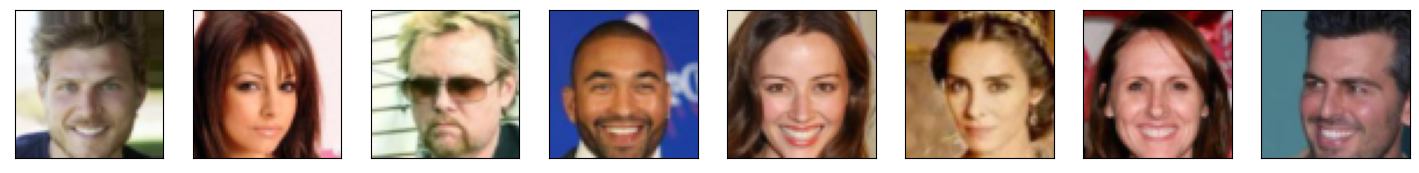

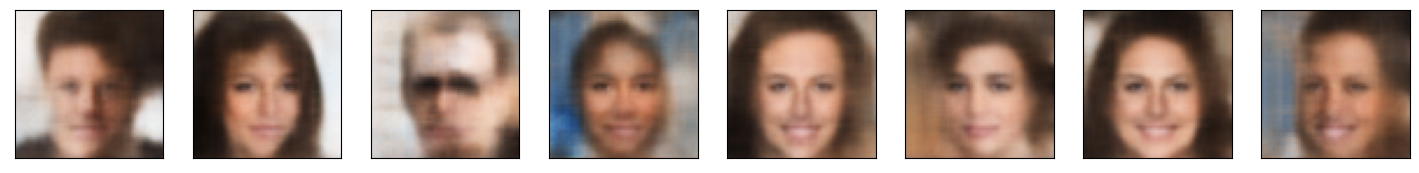

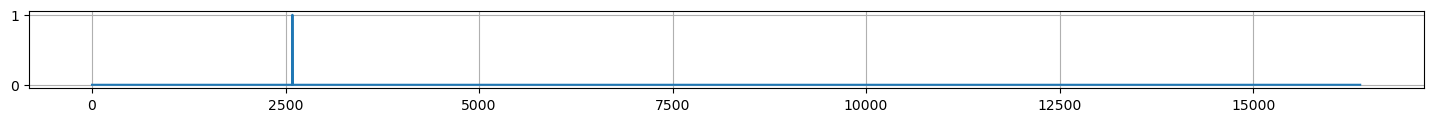

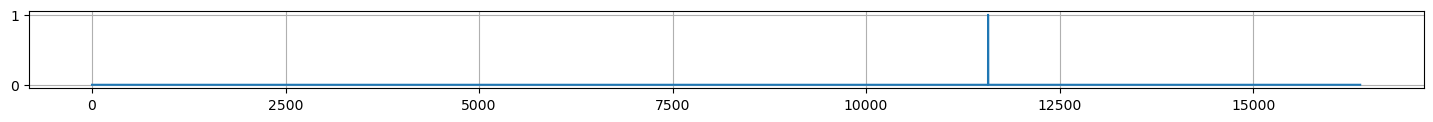

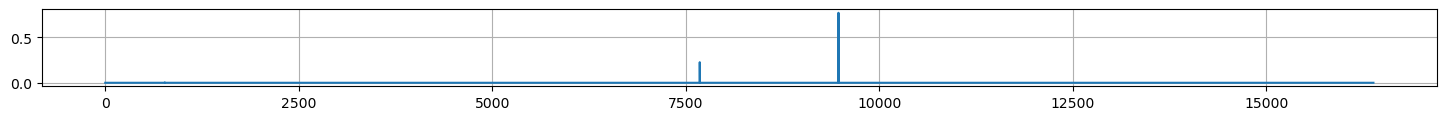

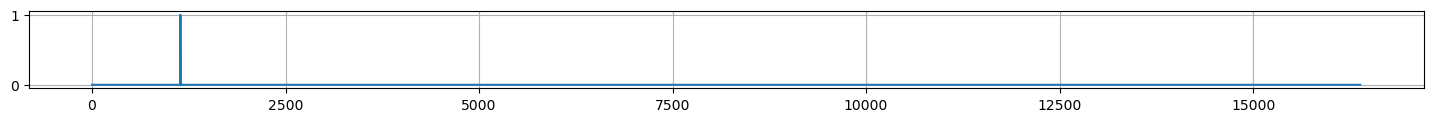

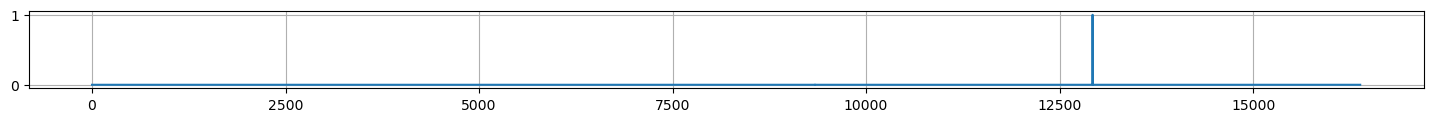

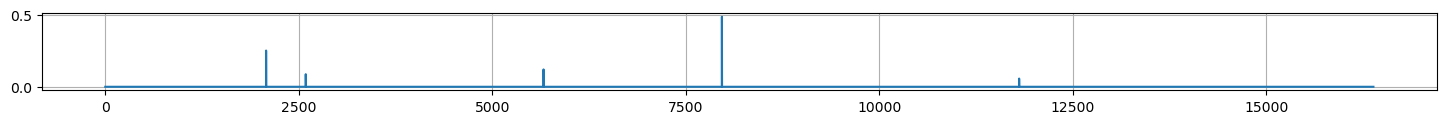

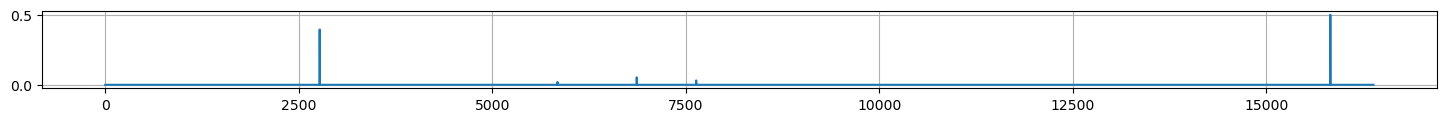

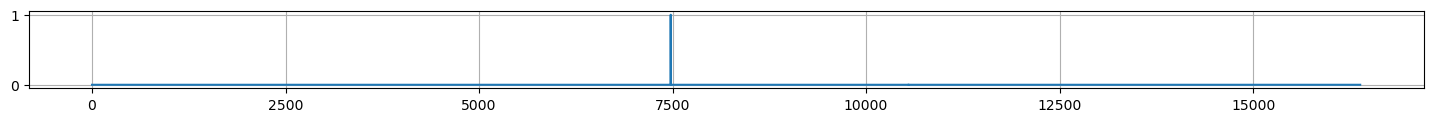

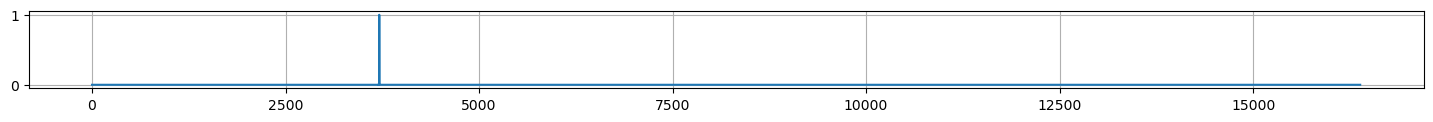

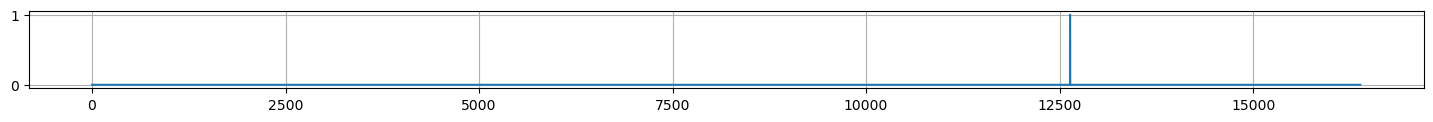

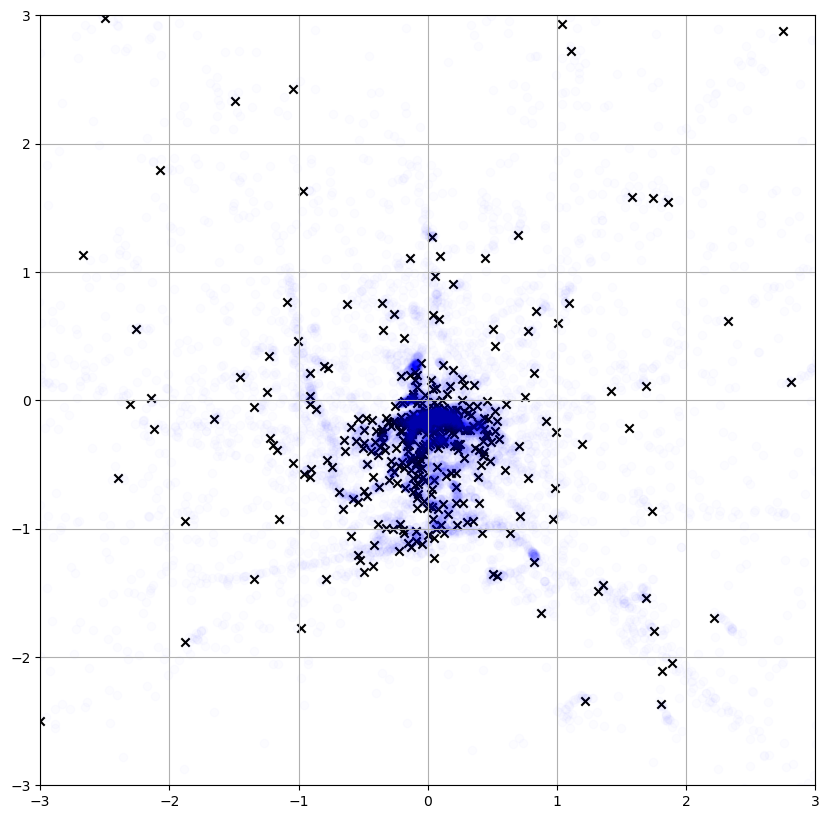

In [23]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.show() 

In [32]:
from tqdm import tqdm

belongs = []
for i, batch in tqdm(enumerate(train_loader)):
    data = preprocess(batch)

    # Forward
    model.eval()
    data = model(data, latent_temp=1)
    belongs.append(data['belong'])

    if i > 2:
        break

3it [00:00, 10.83it/s]


In [33]:
belongs = torch.stack(belongs, dim=0)
print(belongs.shape)

torch.Size([4, 16384, 512])


In [34]:
(belongs.sum(dim=[0, 1]) > 0).sum()

tensor(512, device='cuda:0')